### HAM 10000

* [Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)

* [Original Paper](https://www.nature.com/articles/sdata2018161)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [2]:
PATH = 'datasets/ham10000/'

In [3]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [4]:
df = pd.read_csv(text_path)
df

,image_id,dx,text,split
0,ISIC_0033319,nv,Patient diagnosed via histo. Age: 35 years. Se...,train
1,ISIC_0030823,nv,Patient diagnosed via follow_up. Age: 40 years...,train
2,ISIC_0028730,akiec,Patient diagnosed via histo. Age: 65 years. Se...,train
3,ISIC_0027299,nv,Patient diagnosed via follow_up. Age: 40 years...,train
4,ISIC_0032444,nv,Patient diagnosed via histo. Age: 65 years. Se...,train
...,...,...,...,...
10010,ISIC_0034116,nv,Patient diagnosed via histo. Age: 35 years. Se...,test
10011,ISIC_0026453,bcc,Patient diagnosed via histo. Age: 55 years. Se...,test
10012,ISIC_0029885,mel,Patient diagnosed via histo. Age: 35 years. Se...,test
10013,ISIC_0033226,mel,Patient diagnosed via histo. Age: 65 years. Se...,test


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'image_id'
label_columns = 'dx'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

100%|██████████| 10015/10015 [00:01<00:00, 8089.86it/s]


Train Shape: (8012, 4)
Test Shape: (2003, 4)


In [6]:
train_df

,image_id,dx,text,split
0,datasets/ham10000/images/ISIC_0033319.jpg,nv,Patient diagnosed via histo. Age: 35 years. Se...,train
1,datasets/ham10000/images/ISIC_0030823.jpg,nv,Patient diagnosed via follow_up. Age: 40 years...,train
2,datasets/ham10000/images/ISIC_0028730.jpg,akiec,Patient diagnosed via histo. Age: 65 years. Se...,train
3,datasets/ham10000/images/ISIC_0027299.jpg,nv,Patient diagnosed via follow_up. Age: 40 years...,train
4,datasets/ham10000/images/ISIC_0032444.jpg,nv,Patient diagnosed via histo. Age: 65 years. Se...,train
...,...,...,...,...
8007,datasets/ham10000/images/ISIC_0032692.jpg,vasc,Patient diagnosed via histo. Age: 35 years. Se...,train
8008,datasets/ham10000/images/ISIC_0029317.jpg,nv,Patient diagnosed via follow_up. Age: 45 years...,train
8009,datasets/ham10000/images/ISIC_0025983.jpg,nv,Patient diagnosed via histo. Age: 20 years. Se...,train
8010,datasets/ham10000/images/ISIC_0027256.jpg,vasc,Patient diagnosed via consensus. Age: 0 years....,train


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197895
Epoch 1/30 - Test Accuracy: 0.5726, macro-f1: 0.4294
Epoch 1/30 - Training Time: 276.01 seconds | Inference Time: 66.39 seconds
Epoch 2/30 - Test Accuracy: 0.6565, macro-f1: 0.5038
Epoch 2/30 - Training Time: 265.17 seconds | Inference Time: 62.85 seconds
Epoch 3/30 - Test Accuracy: 0.6550, macro-f1: 0.4882
Epoch 3/30 - Training Time: 261.91 seconds | Inference Time: 65.45 seconds
Epoch 4/30 - Test Accuracy: 0.6455, macro-f1: 0.5495
Epoch 4/30 - Training Time: 263.93 seconds | Inference Time: 65.59 seconds
Epoch 5/30 - Test Accuracy: 0.6970, macro-f1: 0.5535
Epoch 5/30 - Training Time: 261.12 seconds | Inference Time: 64.74 seconds
Epoch 6/30 - Test Accuracy: 0.6296, macro-f1: 0.5723
Epoch 6/30 - Training Time: 258.69 seconds | Inference Time: 65.60 seconds
Epoch 7/30 - Test Accuracy: 0.6635, macro-f1: 0.5713
Epoch 7/30 - Training Time: 263.16 seconds | Inference Time: 63.16 seconds
Epoch 8/30 - Test Accurac

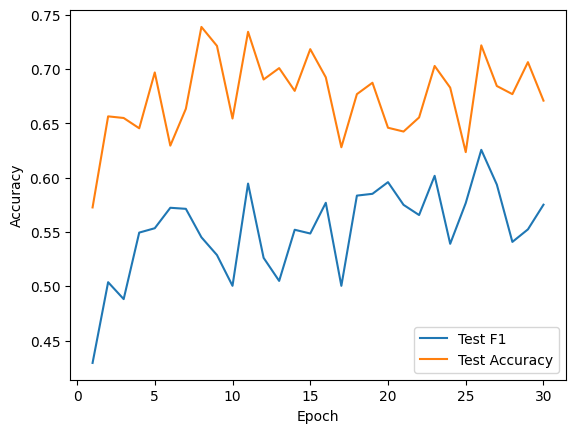

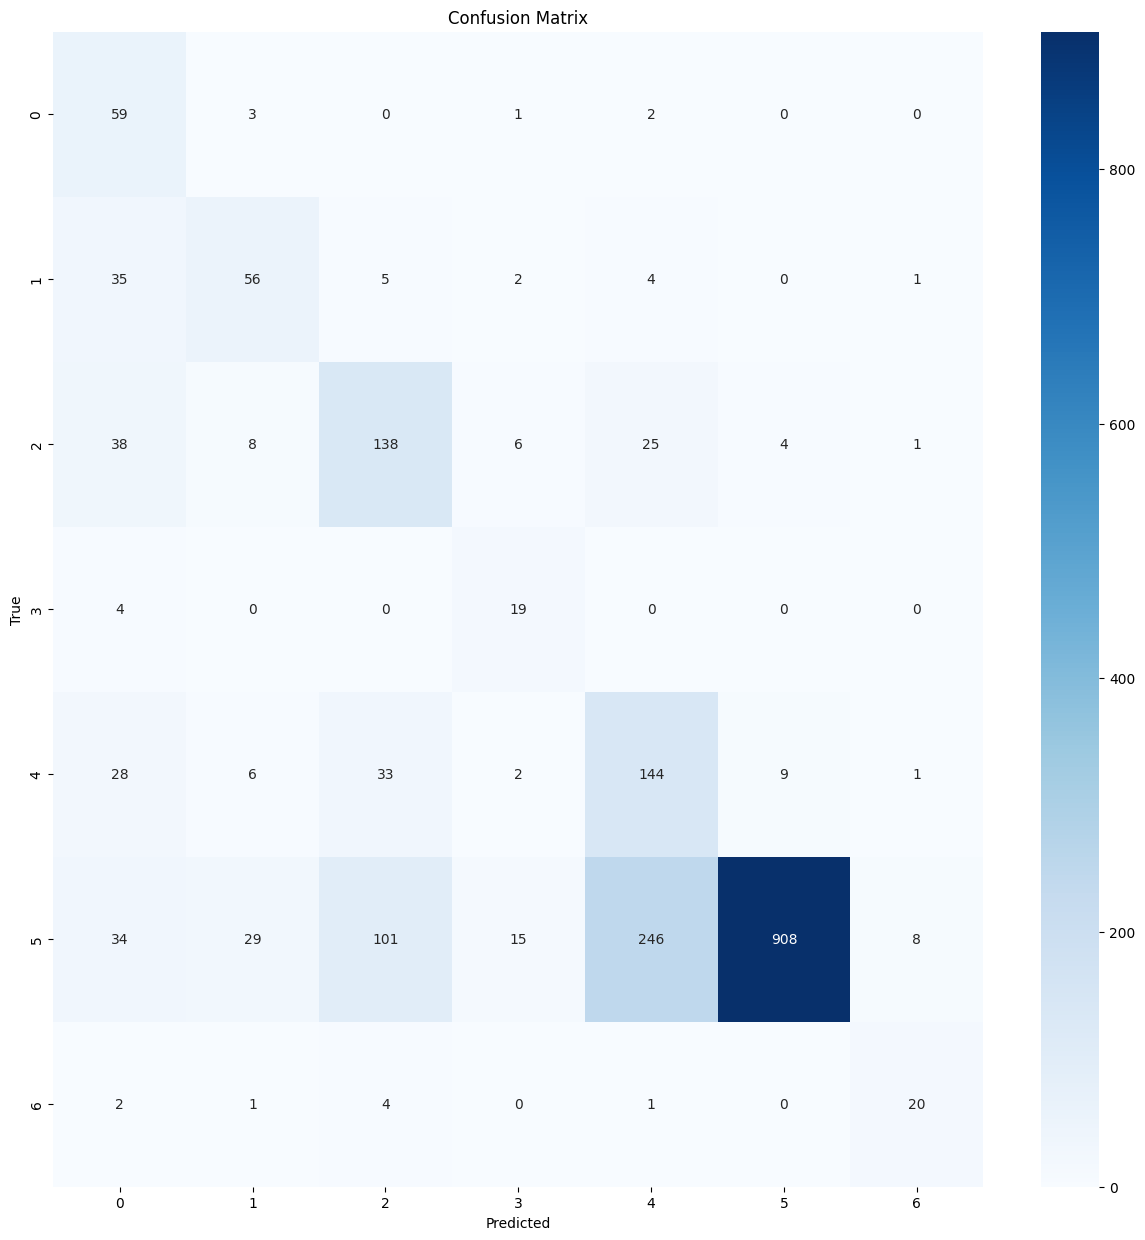

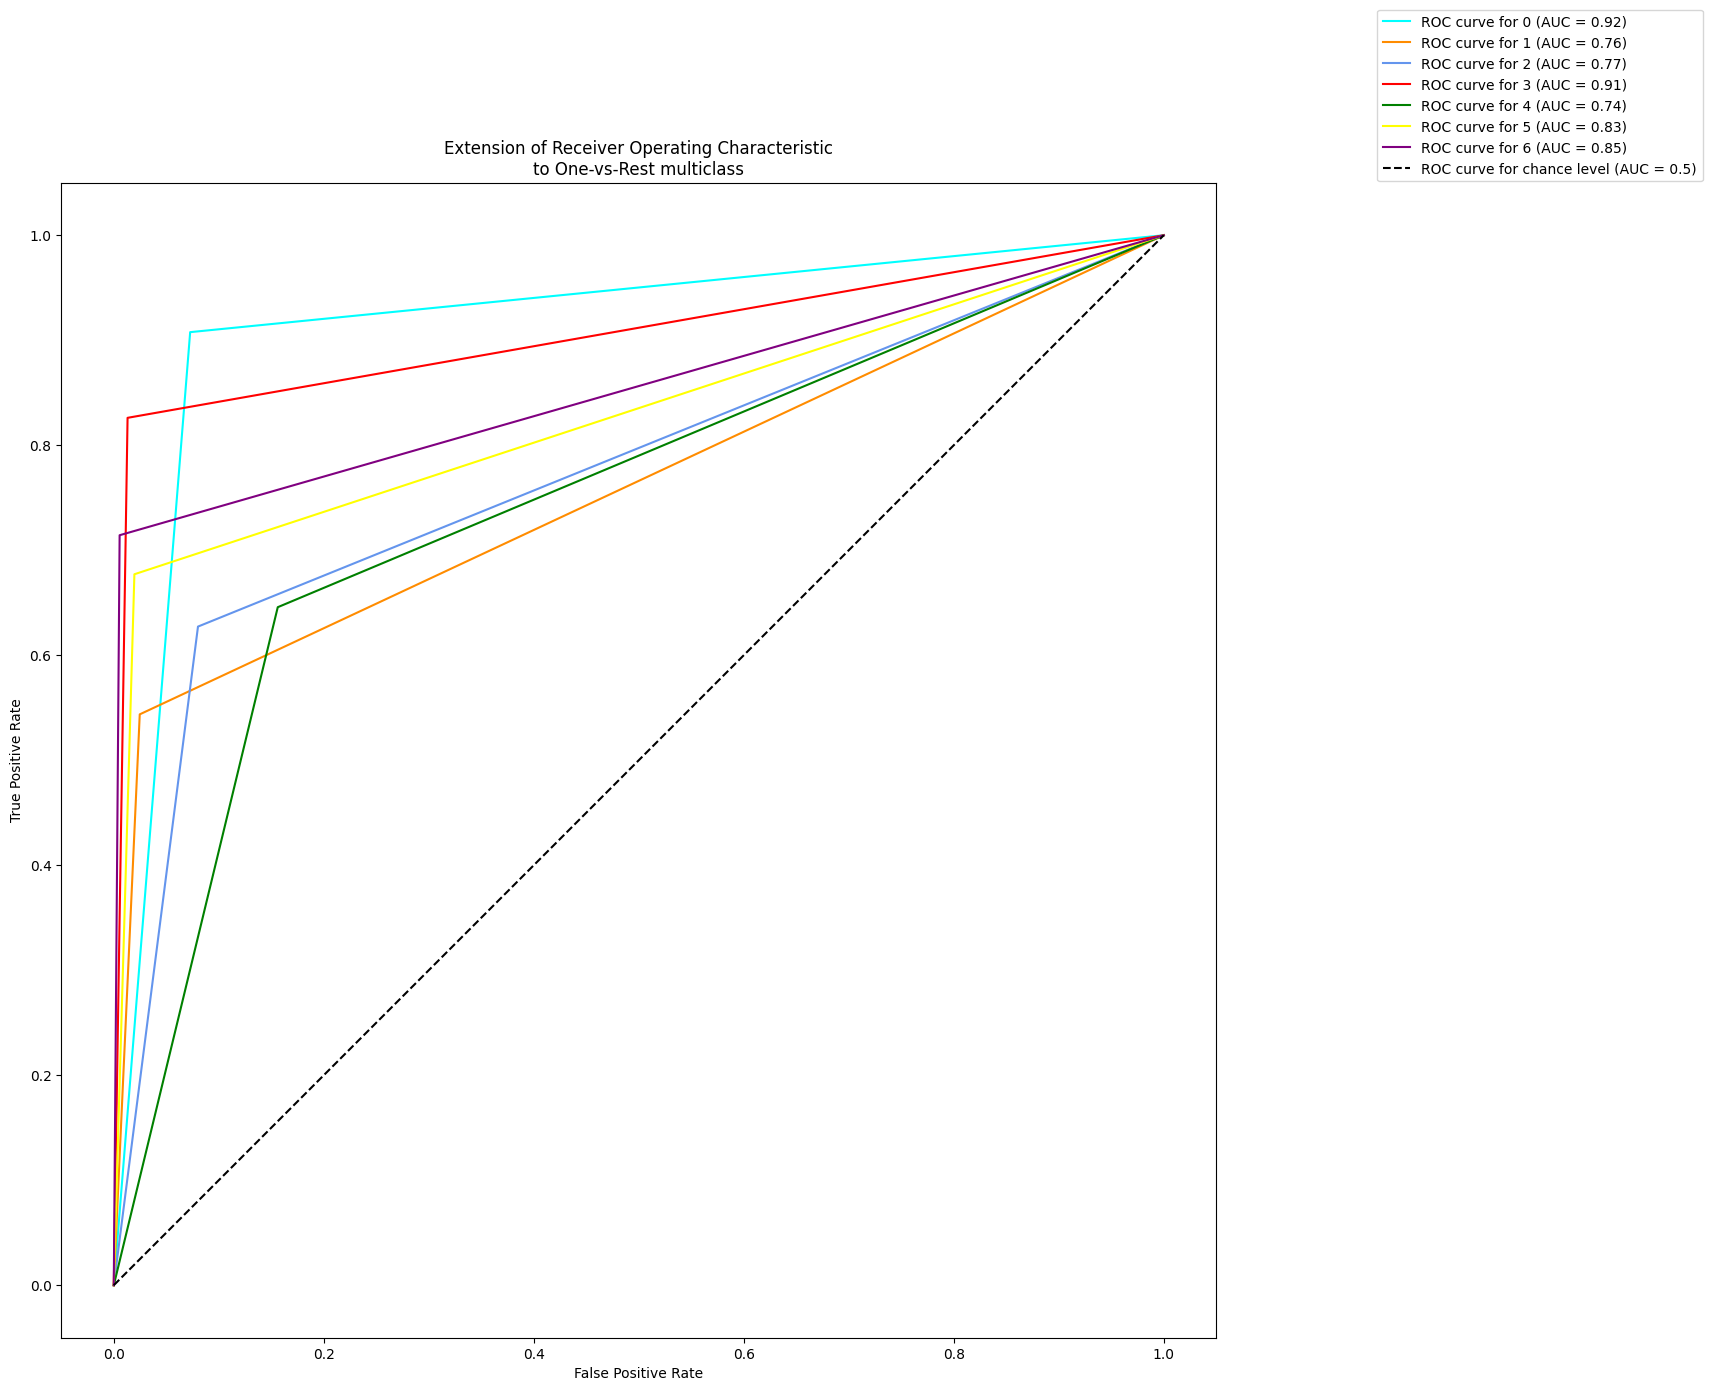

              precision    recall  f1-score   support

           0       0.29      0.91      0.45        65
           1       0.54      0.54      0.54       103
           2       0.49      0.63      0.55       220
           3       0.42      0.83      0.56        23
           4       0.34      0.65      0.45       223
           5       0.99      0.68      0.80      1341
           6       0.65      0.71      0.68        28

    accuracy                           0.67      2003
   macro avg       0.53      0.71      0.58      2003
weighted avg       0.80      0.67      0.71      2003



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 99591
Epoch 1/30 - Test Accuracy: 0.5741, macro-f1: 0.4191
Epoch 1/30 - Training Time: 258.08 seconds | Inference Time: 65.71 seconds
Epoch 2/30 - Test Accuracy: 0.6011, macro-f1: 0.5106
Epoch 2/30 - Training Time: 260.73 seconds | Inference Time: 65.30 seconds
Epoch 3/30 - Test Accuracy: 0.6555, macro-f1: 0.5062
Epoch 3/30 - Training Time: 260.26 seconds | Inference Time: 65.13 seconds
Epoch 4/30 - Test Accuracy: 0.7419, macro-f1: 0.5946
Epoch 4/30 - Training Time: 261.63 seconds | Inference Time: 65.92 seconds
Epoch 5/30 - Test Accuracy: 0.6845, macro-f1: 0.5803
Epoch 5/30 - Training Time: 264.99 seconds | Inference Time: 64.83 seconds
Epoch 6/30 - Test Accuracy: 0.6710, macro-f1: 0.5789
Epoch 6/30 - Training Time: 261.22 seconds | Inference Time: 65.97 seconds
Epoch 7/30 - Test Accuracy: 0.6885, macro-f1: 0.5488
Epoch 7/30 - Training Time: 262.55 seconds | Inference Time: 65.71 seconds
Epoch 8/30 - Test Accuracy:

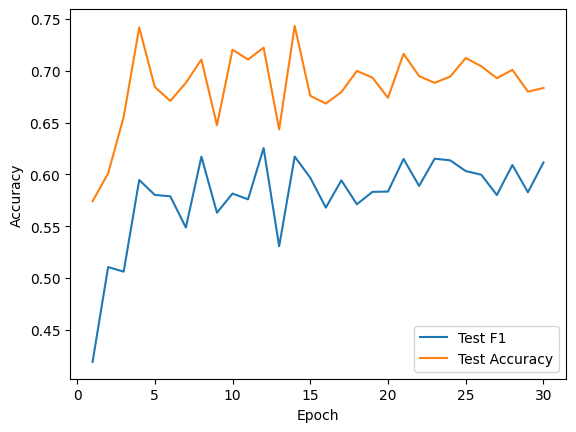

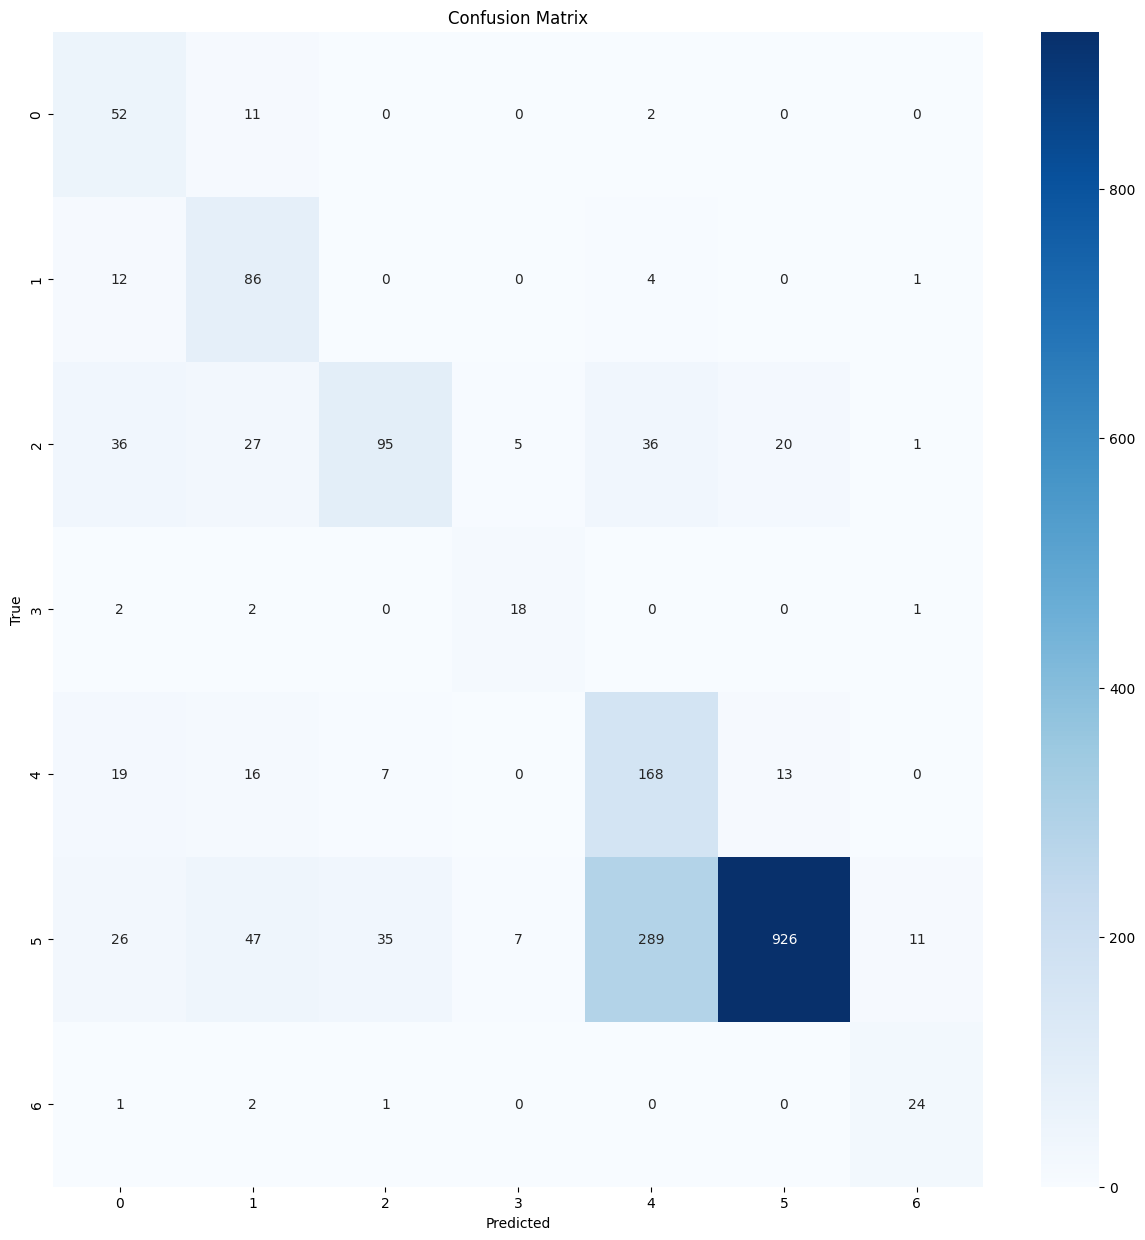

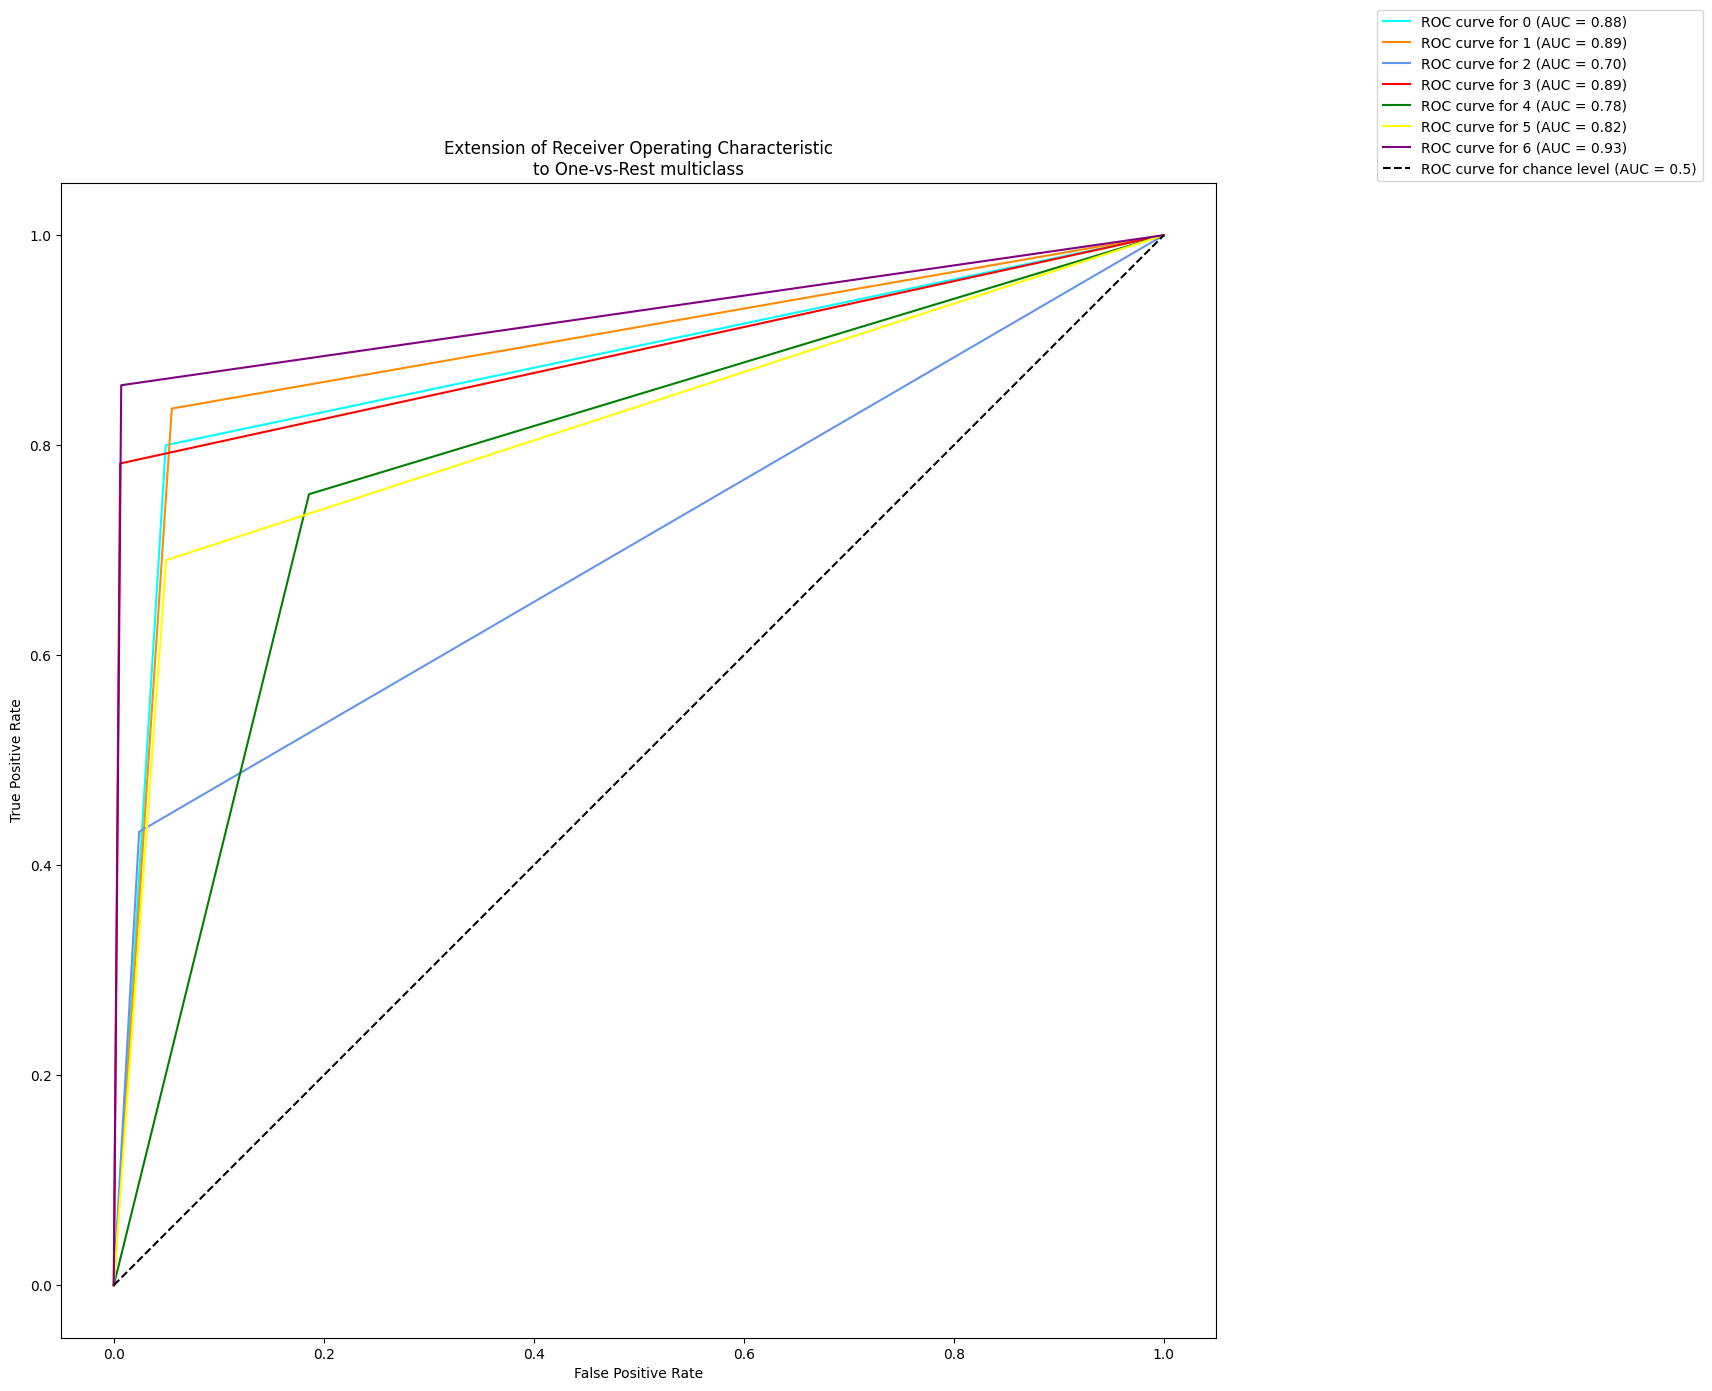

              precision    recall  f1-score   support

           0       0.35      0.80      0.49        65
           1       0.45      0.83      0.59       103
           2       0.69      0.43      0.53       220
           3       0.60      0.78      0.68        23
           4       0.34      0.75      0.47       223
           5       0.97      0.69      0.81      1341
           6       0.63      0.86      0.73        28

    accuracy                           0.68      2003
   macro avg       0.57      0.74      0.61      2003
weighted avg       0.81      0.68      0.71      2003



In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, freeze_backbone=True)